In [1]:
import sys
sys.path.append('..')

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from scipy.interpolate import griddata
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

from noaa.ghcnd import NOAAStore
from extremevalue.gpd import GPDMLE, GEVMLE_ts
from utils.geodata import usa_grid

In [2]:
%load_ext autoreload
%autoreload 2

## Load data from cache

In [3]:
store = NOAAStore()
stations = store.stations()

In [4]:
tmin = store.timeseries_universe(element='TMIN')

In [5]:
def clean_tmin(ts):
    
    min = ts.min()
    pct01 = ts.quantile(0.01)

    return ts[(ts>(pct01-30))&(ts<40)]

In [6]:
tmin_clean = tmin.groupby('id',group_keys=False).apply(clean_tmin)

In [7]:
def coverage(s):
    start = s.index.get_level_values('date').min()
    end = s.index.get_level_values('date').max()
    count = s.count()
    length = (end-start).days+1
    coverage = count/length
    return {'start':start,'end':end,'coverage':coverage}
    

In [8]:
tmin_stats = pd.DataFrame(tmin_clean.groupby('id').apply(coverage)).unstack(1)['value'].sort_values('coverage')

In [9]:
tmin_stats.head()

,start,end,coverage
id,,,
USC00205403,1943-02-13,2022-12-02,0.009263
USC00308455,1941-06-10,2022-10-19,0.05374
USC00256335,1966-08-01,2022-12-21,0.055445
USC00057460,1900-09-01,2022-11-30,0.087232
USC00113312,1900-01-01,2022-04-13,0.089582


In [13]:
def returnlevel_stats(ts,method='gpd'):
    start = ts.index.get_level_values('date').min()
    end = ts.index.get_level_values('date').max()
    count = ts.count()
    length = (end-start).days+1
    coverage = count/length
    
    rl = {
        '10y'     : np.nan,
        '10y_se'  : np.nan,
        '100y'    : np.nan,
        '100y_se' : np.nan,
        'mu'      : np.nan,
        'sigma'   : np.nan,
        'xi'      : np.nan,
        'n_sample': np.nan,
    }
    
    if (count < 10000) | (coverage < 0.85):
        return rl
    
    if method == 'gpd':
        u = ts.quantile(0.995)
        gpd = GPDMLE(u)
        gpd.fit(ts.values)

        period_1y = 365.25

        params = gpd.get_params()
        params['mu'] = u

        rl['10y'] =  gpd.return_level(10.0, period=period_1y)
        rl['10y_se'] =  gpd.return_level_se(10.0, period=period_1y)
        rl['100y'] =  gpd.return_level(100.0, period=period_1y)
        rl['100y_se'] =  gpd.return_level_se(100.0, period=period_1y)
        rl['n_sample'] = len(gpd.x_exceed)

    elif method == 'gev':
        gev = GEVMLE_ts()
        
        ts.index = ts.index.droplevel('id')

        try:
            gev.fit(ts)

            params = gev.get_params()


            rl['10y'] =  gev.return_level(10.0)
            rl['10y_se'] =  gev.return_level_se(10.0)
            rl['100y'] =  gev.return_level(100.0)
            rl['100y_se'] =  gev.return_level_se(100.0)
            rl['n_sample'] = len(gev.x_max)
        except:
            print('failed to fit')


    rl['xi'] = params['xi']
    rl['sigma'] = params['sigma']
    rl['mu'] = params['mu']

    return rl

def returnlevel_stats_gev(ts):
    return returnlevel_stats(ts,method='gev')

def returnlevel_stats_gdp(ts):
    return returnlevel_stats(ts,method='gpd')

In [11]:
tmin_gpd = (-tmin_clean).groupby('id').apply(returnlevel_stats_gdp).unstack(1).dropna()

/Users/mosselveen/dev/extremeweather/.conda/lib/python3.10/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in log
  return f_raw(*args, **kwargs)
/Users/mosselveen/dev/extremeweather/.conda/lib/python3.10/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in sqrt
  return f_raw(*args, **kwargs)
/Users/mosselveen/dev/extremeweather/.conda/lib/python3.10/site-packages/numpy/lib/function_base.py:2412: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


In [14]:
tmin_gev = (-tmin_clean).groupby('id').apply(returnlevel_stats_gev).unstack(1).dropna()

failed to fit


/Users/mosselveen/dev/extremeweather/.conda/lib/python3.10/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in sqrt
  return f_raw(*args, **kwargs)
/Users/mosselveen/dev/extremeweather/.conda/lib/python3.10/site-packages/numpy/lib/function_base.py:2412: RuntimeWarning: invalid value encountered in _return_level_se (vectorized)
  outputs = ufunc(*inputs)


failed to fit


/Users/mosselveen/dev/extremeweather/.conda/lib/python3.10/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in sqrt
  return f_raw(*args, **kwargs)
/Users/mosselveen/dev/extremeweather/.conda/lib/python3.10/site-packages/numpy/lib/function_base.py:2412: RuntimeWarning: invalid value encountered in _return_level_se (vectorized)
  outputs = ufunc(*inputs)


failed to fit
failed to fit
failed to fit
failed to fit


/Users/mosselveen/dev/extremeweather/.conda/lib/python3.10/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in sqrt
  return f_raw(*args, **kwargs)
/Users/mosselveen/dev/extremeweather/.conda/lib/python3.10/site-packages/numpy/lib/function_base.py:2412: RuntimeWarning: invalid value encountered in _return_level_se (vectorized)
  outputs = ufunc(*inputs)


failed to fit
failed to fit
failed to fit
failed to fit
failed to fit
failed to fit
failed to fit
failed to fit


/Users/mosselveen/dev/extremeweather/.conda/lib/python3.10/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in sqrt
  return f_raw(*args, **kwargs)
/Users/mosselveen/dev/extremeweather/.conda/lib/python3.10/site-packages/numpy/lib/function_base.py:2412: RuntimeWarning: invalid value encountered in _return_level_se (vectorized)
  outputs = ufunc(*inputs)
/Users/mosselveen/dev/extremeweather/.conda/lib/python3.10/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in sqrt
  return f_raw(*args, **kwargs)
/Users/mosselveen/dev/extremeweather/.conda/lib/python3.10/site-packages/numpy/lib/function_base.py:2412: RuntimeWarning: invalid value encountered in _return_level_se (vectorized)
  outputs = ufunc(*inputs)


failed to fit
failed to fit


/Users/mosselveen/dev/extremeweather/.conda/lib/python3.10/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in sqrt
  return f_raw(*args, **kwargs)
/Users/mosselveen/dev/extremeweather/.conda/lib/python3.10/site-packages/numpy/lib/function_base.py:2412: RuntimeWarning: invalid value encountered in _return_level_se (vectorized)
  outputs = ufunc(*inputs)


failed to fit


/Users/mosselveen/dev/extremeweather/.conda/lib/python3.10/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in sqrt
  return f_raw(*args, **kwargs)
/Users/mosselveen/dev/extremeweather/.conda/lib/python3.10/site-packages/numpy/lib/function_base.py:2412: RuntimeWarning: invalid value encountered in _return_level_se (vectorized)
  outputs = ufunc(*inputs)


failed to fit
failed to fit
failed to fit
failed to fit
failed to fit
failed to fit
failed to fit
failed to fit
failed to fit
failed to fit
failed to fit
failed to fit
failed to fit
failed to fit
failed to fit
failed to fit


/Users/mosselveen/dev/extremeweather/.conda/lib/python3.10/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in sqrt
  return f_raw(*args, **kwargs)
/Users/mosselveen/dev/extremeweather/.conda/lib/python3.10/site-packages/numpy/lib/function_base.py:2412: RuntimeWarning: invalid value encountered in _return_level_se (vectorized)
  outputs = ufunc(*inputs)


failed to fit
failed to fit
failed to fit


/Users/mosselveen/dev/extremeweather/.conda/lib/python3.10/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in sqrt
  return f_raw(*args, **kwargs)
/Users/mosselveen/dev/extremeweather/.conda/lib/python3.10/site-packages/numpy/lib/function_base.py:2412: RuntimeWarning: invalid value encountered in _return_level_se (vectorized)
  outputs = ufunc(*inputs)


failed to fit


/Users/mosselveen/dev/extremeweather/.conda/lib/python3.10/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in sqrt
  return f_raw(*args, **kwargs)
/Users/mosselveen/dev/extremeweather/.conda/lib/python3.10/site-packages/numpy/lib/function_base.py:2412: RuntimeWarning: invalid value encountered in _return_level_se (vectorized)
  outputs = ufunc(*inputs)


failed to fit
failed to fit
failed to fit
failed to fit
failed to fit
failed to fit
failed to fit
failed to fit


In [30]:
tmin_gev.sort_values('10y_se')

,10y,10y_se,100y,100y_se,mu,sigma,xi,n_sample
id,,,,,,,,
USC00364214,32.19987,7.221566867282411e-12,32.2,3.3774952334517045e-15,31.805225,1.406714,-3.563336,76.0
USC00241044,41.699857,7.739943546291998e-12,41.7,3.5989863592114535e-15,41.257487,1.580557,-3.571775,122.0
USC00391294,49.399956,7.876363478009204e-12,49.4,1.2443323936214293e-15,49.008191,1.582561,-4.039118,97.0
USC00101408,37.199916,8.968646404877998e-12,37.2,2.485947925305862e-15,36.795932,1.521523,-3.76551,111.0
USC00203529,39.999759,9.560030296019866e-12,40.0,4.150363546803853e-15,39.437899,1.936693,-3.445455,101.0
...,...,...,...,...,...,...,...,...
USW00012850,-4.159481,1.3381436370652138,10.119339,6.9090817193079594,-10.710471,1.989836,0.319124,59.0
USC00106844,28.335616,1.3427336005805368,39.771134,4.231497881760228,16.869829,5.210284,-0.019947,89.0
USC00264349,22.264127,1.3435751051363443,34.267819,5.4700748599370055,13.398521,3.460535,0.11285,75.0


In [17]:
# tmin_gev[tmin_gev['xi'].abs()<0.0001]

## Compute statistics
* Coverage
* Return levels + standard errors
* Mean 

In [81]:
tmin_l48 = tmin_gev[['10y','10y_se']].join(stations).loc[lambda df: ~df['state'].isin(['AK','HI'])]
tmin_l48[['10y','10y_se']] = tmin_l48[['10y','10y_se']].astype('float')
tmin_l48 = tmin_l48.dropna()
tmin_l48.sort_values('10y_se')

,10y,10y_se,latitude,longitude,elevation,state,name,country
id,,,,,,,,
USC00364214,32.199870,7.221567e-12,40.5972,-79.1186,335.9,PA,INDIANA 3 SE,US
USC00241044,41.699857,7.739944e-12,45.6622,-111.0464,1497.5,MT,BOZEMAN MONTANA STATE UNIV,US
USC00391294,49.399956,7.876363e-12,45.5489,-103.9744,951.0,SD,CAMP CROOK,US
USC00101408,37.199916,8.968646e-12,44.5733,-116.6753,807.7,ID,CAMBRIDGE,US
USC00203529,39.999759,9.560030e-12,44.4633,-83.7217,221.9,MI,HALE LOUD DAM,US
...,...,...,...,...,...,...,...,...
USW00012850,-4.159481,1.338144e+00,24.5833,-81.6833,1.8,FL,KEY WEST NAS,US
USC00106844,28.335616,1.342734e+00,43.8022,-116.9442,698.0,ID,PARMA EXP STN,US
USC00264349,22.264127,1.343575e+00,39.4689,-119.0644,1270.1,NV,LAHONTAN DAM,US


## Interpolate Using Gaussian Processes

### Define Grid Variables (for the lower 48)

In [33]:
x_mesh, y_mesh, usa_mask = usa_grid(n_width=500, n_height=400)
x_1d = x_mesh.ravel()
y_1d = y_mesh.ravel()

In [82]:
x_x = tmin_l48['longitude'].values
x_y = tmin_l48['latitude'].values
x_z = tmin_l48['elevation'].values/1000 #elevation in km

y = -tmin_l48['10y'].astype('float').values
y_var = np.power(tmin_l48['10y_se'].astype('float').values,2.0)
X2 = np.array([x_x,x_y]).T
X3 = np.array([x_x,x_y,x_z]).T

In [83]:


kernel = 1.0 * RBF(length_scale=(1e0,1e0), length_scale_bounds=(1e-3, 1e4))
kernel += WhiteKernel( noise_level=1e-4, noise_level_bounds=(1e-8, 1e-1))
# gpr_prcp = GaussianProcessRegressor(kernel=kernel, alpha=y_var,  n_restarts_optimizer=2)

# kernel = 10.0 * RBF(length_scale=(0.75,1.0), length_scale_bounds='fixed')
gpr_tmin = GaussianProcessRegressor(kernel=kernel, alpha=y_var, normalize_y=True)

gpr_tmin.fit(X2,y)

GaussianProcessRegressor(alpha=array([2.64504373e-01, 1.99699735e-01, 2.83076874e-01, ...,
       1.30083721e-01, 2.94237172e-01, 8.28673352e-20]),
                         kernel=1**2 * RBF(length_scale=[1, 1]) + WhiteKernel(noise_level=0.0001),
                         normalize_y=True)

In [84]:
print('fit', gpr_tmin.kernel_)

fit 1.94**2 * RBF(length_scale=[8.32, 11.4]) + WhiteKernel(noise_level=0.0538)


In [85]:
X_pred = np.array([x_1d,y_1d]).T
y_pred, y_pred_z = gpr_tmin.predict(X_pred, return_std=True)

y_pred_mesh = y_pred.reshape(x_mesh.shape).copy()
y_pred_mesh[~usa_mask.reshape(x_mesh.shape)]=np.nan

nan

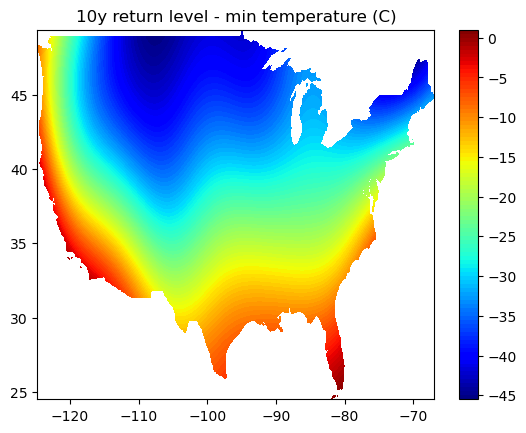

In [86]:
plt.contourf(x_mesh,y_mesh,y_pred_mesh,100,cmap='jet')
plt.colorbar()
plt.title('10y return level - min temperature (C)');